In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(context='paper', style='whitegrid', rc={'figure.figsize':(8, 5), 'figure.dpi': 120})
color_palette = sns.color_palette("Set2")
sns.set_palette(color_palette)

seed_ = 20200218
np.random.seed(seed_)


import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, RNN, Activation
from keras.optimizers import *

import tensorflow as tf
tf.random.set_seed(seed_)
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [2]:
df = pd.read_csv("./data/sunspots.csv")

In [3]:
df.head()

,Unnamed: 0,Date,Monthly Mean Total Sunspot Number
0,0,1749-01-31,96.7
1,1,1749-02-28,104.3
2,2,1749-03-31,116.7
3,3,1749-04-30,92.8
4,4,1749-05-31,141.7


### drop first column and rename column

In [4]:
df.drop(columns=[df.columns[0]], axis=1, inplace=True)

In [5]:
df.rename(columns={df.columns[1]: 'monthly_sunspot'}, inplace=True)

In [6]:
df['Date'] = pd.to_datetime(df['Date'])

In [7]:
df.head()

,Date,monthly_sunspot
0,1749-01-31,96.7
1,1749-02-28,104.3
2,1749-03-31,116.7
3,1749-04-30,92.8
4,1749-05-31,141.7


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3252 entries, 0 to 3251
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             3252 non-null   datetime64[ns]
 1   monthly_sunspot  3252 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 50.9 KB


## 
### preprocessing function

In [9]:
def windowing_arr(series, window_size, shuffle_buffer):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda window: (window[:-1], window[-1:]))
    return ds

def tensor_ds_to_X_Y(tensor_ds):
    X = []
    Y = []
    
    for window in ds:
        x, y = window
        X.append(x.numpy())
        Y.append(y.numpy())
    X = np.asarray(X)
    Y = np.asarray(Y)
    return X, Y

#### preprocessing data

In [10]:
window_size = 30
batch_size = 24
shuffle_buffer = 1000

split_time = 2800

sunspot = df['monthly_sunspot']

train = sunspot[:split_time]
dev = sunspot[split_time:]

ds = windowing_arr(train, window_size, shuffle_buffer)
X, Y = tensor_ds_to_X_Y(ds)

ds_dev = windowing_arr(dev, window_size, shuffle_buffer)
X_dev, Y_dev = tensor_ds_to_X_Y(ds_dev)

## 
### Model

In [11]:
model = Sequential()
model.add(Dense(4, input_shape=[window_size], activation='relu'))
model.add(Dense(1))

In [12]:
model.compile(optimizer='adam', loss='mean_absolute_error')

In [13]:
hist = model.fit(X, Y, epochs=50, batch_size=batch_size, validation_data=(X_dev, Y_dev))

Epoch 1/50
116/116 [==============================] - 0s 4ms/step - loss: 90.5687 - val_loss: 50.4933
Epoch 2/50
116/116 [==============================] - 0s 3ms/step - loss: 40.8686 - val_loss: 38.8963
Epoch 3/50
116/116 [==============================] - 0s 3ms/step - loss: 33.7517 - val_loss: 30.8851
Epoch 4/50
116/116 [==============================] - 0s 3ms/step - loss: 29.9159 - val_loss: 28.0973
Epoch 5/50
116/116 [==============================] - 0s 3ms/step - loss: 27.4608 - val_loss: 26.0545
Epoch 6/50
116/116 [==============================] - 0s 3ms/step - loss: 25.5326 - val_loss: 24.1421
Epoch 7/50
116/116 [==============================] - 0s 3ms/step - loss: 23.7636 - val_loss: 22.8082
Epoch 8/50
116/116 [==============================] - 0s 4ms/step - loss: 23.0260 - val_loss: 21.6791
Epoch 9/50
116/116 [==============================] - 0s 3ms/step - loss: 21.3990 - val_loss: 21.5712
Epoch 10/50
116/116 [==============================] - 0s 3ms/step - loss: 20.6860

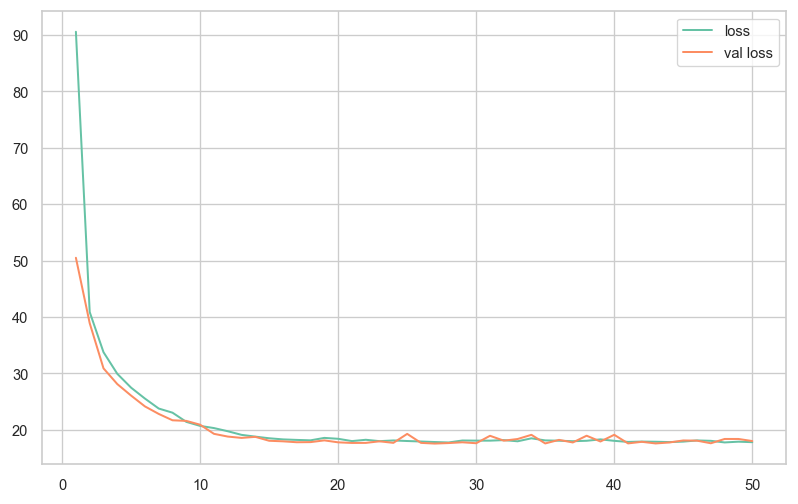

In [14]:
loss = hist.history['loss']
loss_val = hist.history['val_loss']
t = np.arange(1, len(loss)+1)
sns.lineplot(t, loss, label='loss')
t_val = np.arange(1, len(loss_val)+1)
sns.lineplot(t_val, loss_val, label='val loss')

In [15]:
X[0]

array([ 21.3,  41.7,  85.5,  66.2,  54.2, 107.8,  55.8,  62.7,  86.7,
        81.7, 120.5,  77.3,  75. ,  73.3,  64.5, 104.2,  62.8,  71.7,
        71.7,  80.5,  73.3,  78. ,  78.3,  81.7,  83.3,  85. , 118.8,
       128.7,  99.5,  77.2])

In [16]:
Y[0]

array([95.])

In [17]:
model.predict(np.array([X[0]]))

array([[92.238884]], dtype=float32)

## plot predicted

In [18]:
sample_size = len(sunspot)
sample_size

3252

In [19]:
window_size

30

In [ ]:
predicted = []
for time in range(sample_size-window_size):
    x = sunspot[time:time+window_size]
    predicted.append(model.predict(np.array([x])))

In [ ]:
predicted = np.array(predicted).squeeze()

In [ ]:
x = np.arange(sample_size)
sns.lineplot(x, sunspot, label='actual')
sns.lineplot(x[window_size:], predicted, label='forecast')

In [ ]:
x = np.arange(split_time, sample_size)
sns.lineplot(x, sunspot[split_time:], label='actual')
sns.lineplot(x, predicted[split_time-window_size:], label='forecast')